In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import plotly as py
import cufflinks as cf

cf.go_offline()

import numpy as np
import pandas as pd

In [38]:
'''Se hace un read del dataset seleccionado'''

df = pd.read_csv('data/Population-EstimatesData.csv')

In [39]:
df.head(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2042,2043,2044,2045,2046,2047,2048,2049,2050,Unnamed: 95
0,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,88.061110,89.489513,90.782451,91.898948,92.728007,93.20129,...,54.356396,54.502067,54.676725,54.874161,55.102246,55.331887,55.562180,55.789065,56.009450,NaN
1,Arab World,ARB,"Age dependency ratio, old",SP.POP.DPND.OL,6.591951,6.700903,6.793279,6.867327,6.919224,6.94779,...,13.345549,13.732773,14.132766,14.544481,14.946251,15.349197,15.755873,16.168726,16.589418,NaN


In [40]:
'''Se observa que la variable año esta como headers y eso puede suponer un problema a la hora de tratar los datos.
Primero se mira cuantas variables se tienen y cuantos paises para conocer un poco mejor el Dataset'''

countries = df['Country Name'].unique()
indicators = df['Indicator Name'].unique()
print(f'We have: {len(countries)} counties')
print(f'We have: {len(indicators)} indicators')

We have: 259 counties
We have: 175 indicators


In [41]:
'''Para conseguir poner el año como columna se fijan las 4 primeras columnas como indices'''

df = df.set_index(['Country Name','Country Code','Indicator Name','Indicator Code'])

In [42]:
'''Se hace un stack para poder poner el año como una columna, se convierte en un DeFrame y se resetea el indice'''

df = df.stack()
df = pd.DataFrame(df)
df = df.reset_index()

In [43]:
'''Se renombran las columnas para poder trabajar con ellas mejor posteriormente'''

df = df.rename(columns={0:'Values','level_4':'Year'})

In [44]:
'''Se realiza una pivot table para tener los indicadores como columnas'''

df = df.pivot_table(index=['Country Name','Country Code','Year'],columns=['Indicator Name'],values='Values')

In [69]:
df = df.reset_index()
df.head(3)

Indicator Name,index,Country Name,Country Code,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old","Age dependency ratio, young","Age population, age 00, female, interpolated","Age population, age 00, male, interpolated","Age population, age 01, female, interpolated",...,"Population, female (% of total population)","Population, male","Population, male (% of total population)","Population, total",Rural population,Rural population (% of total population),Rural population growth (annual %),Urban population,Urban population (% of total population),Urban population growth (annual %)
0,0,Afghanistan,AFG,1960,81.617277,5.082210,76.535066,179444.0,178269.0,163013.0,...,48.320662,4649576.0,51.679338,8996973.0,8241137.0,91.599,1.528858,755836.0,8.401,5.156936
1,1,Afghanistan,AFG,1961,82.688685,5.130137,77.558548,183622.0,182276.0,172255.0,...,48.412689,4730252.0,51.587311,9169410.0,8373138.0,91.316,1.589040,796272.0,8.684,5.211641
2,2,Afghanistan,AFG,1962,83.289387,5.139642,78.149745,186652.0,186730.0,170911.0,...,48.499387,4816049.0,51.500613,9351441.0,8512056.0,91.024,1.645479,839385.0,8.976,5.272864


In [46]:
'''Se mira que columnas tienen un mayor % de valores nulos para eliminarlas'''

null_cols = df.isnull().sum()/len(df)*100
drop_col = null_cols[null_cols>50].sort_values(ascending=False)
drop_col

Indicator Name
Probability of dying at age 5-14 years (per 1,000 children age 5)    95.002563
Number of deaths ages 5-14 years                                     95.002563
Mortality rate, under-5, male (per 1,000)                            95.002563
Mortality rate, under-5, female (per 1,000)                          95.002563
Mortality rate, infant, male (per 1,000 live births)                 95.002563
Mortality rate, infant, female (per 1,000 live births)               95.002563
Net migration                                                        81.983598
Sex ratio at birth (male births per female births)                   74.000513
Number of neonatal deaths                                            58.077055
Mortality rate, neonatal (per 1,000 live births)                     57.393644
Number of under-five deaths                                          54.100461
Number of infant deaths                                              52.225355
Mortality rate, under-5 (per 1,000)  

In [47]:
df = df.drop(columns=list(drop_col.index))

In [48]:
df['Year'] = df['Year'].astype(int)

In [49]:
#columns = [col for col in df.columns if 'age' not in col]

In [50]:
countries.sort()

In [95]:
'''En este grafico lo que se quiere mostrar es todas aquellas variables porcentuales (%) para poder comparar paises.
El widget te permite seleccionar la variable que quieres analizar y a la vez 
seleccionar todos aquellos paises que quieras comparar/graficar'''

sns.set_style("whitegrid")

from ipywidgets import interact
def make_plot(y='Population, female (% of total population)',country='Brazil'):
    
    xf=df[['Country Name','Year',y]][(df['Country Name'].isin(list(country)))]
    
    sns.relplot(data = xf, x = 'Year', y = y, hue='Country Name',kind='line',height=5, aspect=3) 
    
    
_= interact(make_plot, y=list([i for i in df.columns if '%' in i]), country = widgets.SelectMultiple(options=countries))


interactive(children=(Dropdown(description='y', index=45, options=('Age dependency ratio (% of working-age pop…

In [68]:
'''En este grafico hace lo mismo que el anterior pero para aquellas variables que no son %'''

def make_plot(y='Life expectancy at birth, female (years)',country='Brazil'):
    
    xf=df[['Country Name','Year',y]][(df['Country Name'].isin(list(country)))]
    
    sns.relplot(data = xf, x = 'Year', y = y, hue='Country Name',kind='line',height=5, aspect=3) 
    
columns = [col for col in df if 'Population ages' not in col]
columns = [col for col in columns if 'population' not in col]

_= interact(make_plot, y=list([i for i in columns if '%' not in i]), country = widgets.SelectMultiple(options=countries))


interactive(children=(Dropdown(description='y', index=8, options=('Country Name', 'Country Code', 'Year', 'Age…

In [53]:
'''En el siguiente grafico lo que se quiere mostrar es para un año y un pais en concreto 
la distribucion por edades de la poblacion asi como por genero. Para ello se hace una 
seleccion/limpieza de las columnas que interesan y posteriormente se procede a hacer el grafico'''

columns = [col for col in df if '%' not in col]
columns = [col for col in columns if 'Population ages' in col]
columns = [col for col in columns if 'total' not in col]
columns = [col for col in columns if '15-64' not in col]
columns = [col for col in columns if '65 and above' not in col]

In [54]:
def make_plot2(country='Spain', year=2020):
    plt.figure(figsize=(8,10))
    xp=df[(df['Country Name']==country)&(df['Year']==year.astype(int))]
    xp = pd.DataFrame(xp)
    xp = xp[xp.columns.intersection(columns)].stack()
    xp = xp.reset_index()
    xp = xp.rename(columns={0:'Values'})
    xp = xp.drop(xp.index[:3])
    xp['Color']=np.where(xp['Indicator Name'].str.contains('female'),'Female','Male')
       
    sns.barplot(x='Values', y='Indicator Name',data=xp, hue='Color',alpha = 0.9, edgecolor = 'k', linewidth = 1)
    
_= interact(make_plot2, country =countries, year=[i for i in list(df['Year'].unique())])

interactive(children=(Dropdown(description='country', index=216, options=('Afghanistan', 'Albania', 'Algeria',…

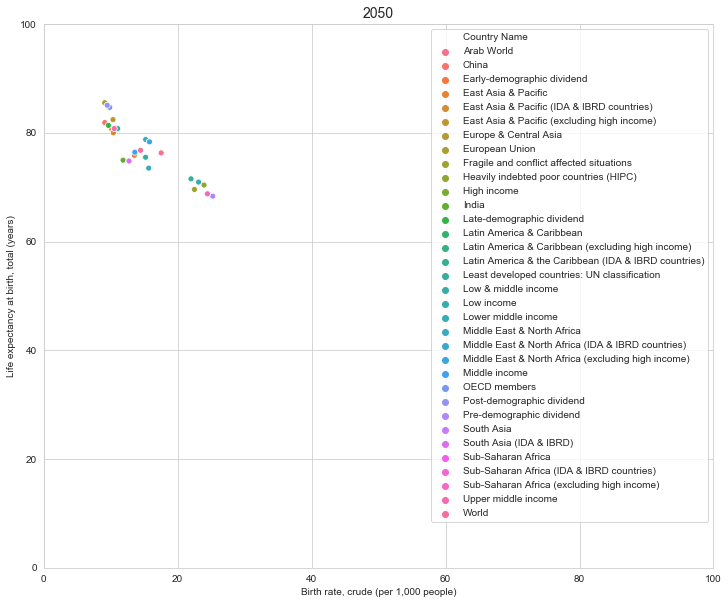

In [55]:
'''Para esta parte se ha querizo hacer un grafico animado que mostrara la 
evolucion de una metrica a lo largo del tiempo. 
- Se queria que fuera bubble pero no se ha conseguido
- El dataset no daba mucha posibilidad de imaginacion para este tipo de grafico
- Se han seleccionado solo las regiones''/paises/continentes de mayor poblacion ya que 
    el grafico pesaba demasiado y tardaba mucho en cargar'''


n = df['Year'].unique()
n = n[n<2020]
for i in n:
    plt.figure(figsize=(12,10))
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    test=df[(df['Year']==i)&(df['Population, total']>500000000)]
    sns.scatterplot(x='Birth rate, crude (per 1,000 people)', y='Life expectancy at birth, total (years)',
                    data=test, hue='Country Name')
    ax = plt.gca()
    ax.set_title(i,fontsize=14)
    plt.show()
    clear_output(wait=True)




In [96]:
'''Un histograma que tambien esta animado y permite ver el numero de paises vs el ratio de fertilidad con 
el paso de los años. Claramente se observa que con el paso de los años la natalidad va bajando'''


n = df['Year'].unique()
n = n[n<2017]
for i in n:
    plt.figure(figsize=(14,8))
    plt.xlim(0, 10)
    plt.ylim(0, 60)
    data_hist=df[df['Year']==i]
    plt.hist(x=data_hist['Fertility rate, total (births per woman)'],bins=20,alpha=0.6)
    
    
    ax = plt.gca()
    
    ax.set_title(i,loc='center',pad=15,fontsize=18)
    ax.set_xlabel("Births per woman",fontsize=16)
    ax.set_ylabel("Num Counties",fontsize=16,labelpad=20)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    clear_output(wait=True)
    


plt.figure(figsize=(14,8))

plt.show()

<Figure size 1008x576 with 0 Axes>